The goal of this notebook is to try train a CNN to distinguish between left motion and right motion...

In [1]:
# ------- Imports -----------

import numpy as np
from numpy import random as rd

import keras as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.regularizers import l1_l2
from keras.layers import Dense, Dropout, Input, Activation, Flatten 
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.datasets import mnist
from keras import backend as KB
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import copy

import PIL as pil
from PIL import Image as im
from PIL import ImageDraw as imdraw

from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# load the dataset...

In [27]:
data = np.load("data.npz")

for key in data.keys():
    print(key)
    
data_left = data["left"]
data_right = data["right"]

data_left.shape

left
right


(10000, 28, 28, 6)

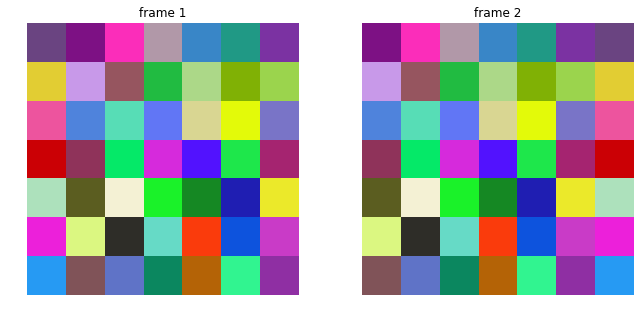

In [28]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax1.axis("off")
ax1.set_title("frame 1")
_ = ax1.imshow(data_left[0,:,:,:3],cmap="hot")

ax2 = fig.add_subplot(122)
ax2.axis("off")
ax2.set_title("frame 2")
_ = ax2.imshow(data_left[0,:,:,3:],cmap="hot")

plt.show()

In [29]:
# create the total combined dataset

total_dataset = np.concatenate((data_left,data_right),axis=0)

In [32]:
x_train = total_dataset
y_train = np.zeros((20000,2))
for j in range(10000):
    y_train[j,0] = 1                # left
for j in range(10000,20000):
    y_train[j,1] = 1                # right
    
x_train = x_train/255

In [138]:
# We start off by specifying that our cnn is a Sequential object
cnn = Sequential()

# Add the first conv layer:
cnn.add(Conv2D(32, (3, 3), input_shape=(28,28,6)))
cnn.add(Activation('relu'))

# We also use batch normalization between conv layers - see here https://arxiv.org/abs/1502.03167
BatchNormalization(axis=-1)

# Another conv layer
cnn.add(Conv2D(32, (3, 3)))
cnn.add(Activation('relu'))

# Max Pooling (Coarse Graining)
cnn.add(MaxPooling2D(pool_size=(2,2)))

# etc...
BatchNormalization(axis=-1)
cnn.add(Conv2D(64,(3, 3)))
cnn.add(Activation('relu'))
BatchNormalization(axis=-1)
cnn.add(Conv2D(64, (3, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

# Finally, we flatten the output of the last conv layer, so that it can be fed into fully connected layers...
cnn.add(Flatten())

# Fully connected layers - a FFNN on top of the conv layers
BatchNormalization()
cnn.add(Dense(512))
cnn.add(Activation('relu'))
BatchNormalization()
cnn.add(Dropout(0.2))
cnn.add(Dense(2))

# We use a softmax as the final activation (ensures a legitimate probability distribution)
cnn.add(Activation('softmax'))

In [34]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        1760      
_________________________________________________________________
activation_13 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_15 (Activation)   (None, 10, 10, 64)        0         
__________

In [190]:
cnn.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [191]:
# ------ Training Parameters -------

batch_size = 128
max_epochs = 2
validation_split = 0.4
stopping_patience = 6
lr_decay_factor = 0.2
lr_patience = 3
lr_min = 0.0001
lr_cooldown = 2

# -------- Callbacks ----------------
        
early_stopping = EarlyStopping(monitor="val_acc", mode='auto',patience=stopping_patience)

LR_schedule = ReduceLROnPlateau(monitor="val_acc", 
                                      factor=lr_decay_factor, 
                                      patience=lr_patience, 
                                      verbose=1, 
                                      mode='auto', 
                                      min_delta=0.0001, 
                                      cooldown=lr_cooldown, min_lr=lr_min)

In [192]:
training_history = cnn.fit(x_train, y_train,
                            batch_size=batch_size, 
                            epochs=max_epochs, verbose=1, 
                            validation_split=validation_split,
                            callbacks = [early_stopping, LR_schedule],
                            shuffle=True)

Train on 12000 samples, validate on 8000 samples
Epoch 1/2
12000/12000 [==============================] - 22s 2ms/step - loss: 0.0046 - acc: 0.9983 - val_loss: 1.0394e-04 - val_acc: 1.0000
Epoch 2/2
12000/12000 [==============================] - 22s 2ms/step - loss: 2.5263e-05 - acc: 1.0000 - val_loss: 6.2121e-05 - val_acc: 1.0000


In [211]:
output_index = 1

# define a placeholder for the input image_vector (the flattened image)
input_image = cnn.input

# define the loss function - which is precisely just the mean of the probability of the given character across the batch
cnn_loss = KB.mean(cnn.output[:, output_index])

# compute the gradient of the input picture wrt this loss
cnn_grads = KB.gradients(cnn_loss, input_image)[0]

# normalization trick: we normalize the gradient
cnn_grads /= (KB.sqrt(KB.mean(KB.square(cnn_grads))) + 1e-5)

# this function returns the loss and grads given the input picture
cnn_iterate = KB.function([input_image], [cnn_loss, cnn_grads])

In [206]:
def batched_image(image):
    return image[None]

def normal_image(batched_image):
    return batched_image[0,:,:,:]

In [207]:
imsize = 28
cell_width = 4
cell_size = cell_width

def choose_random_colour():
    return (rd.randint(256),rd.randint(256),rd.randint(256))

def translate_to_left(your_image):
    first_column = your_image.crop((0,0,cell_width,imsize))
    your_image = your_image.transform(your_image.size, im.AFFINE, (1, 0, cell_width, 0, 1, 0))
    your_image.paste(first_column,(imsize-cell_width,0))
    return your_image

def translate_to_right(your_image):
    last_column = your_image.crop((imsize-cell_width,0,imsize,imsize))
    your_image = your_image.transform(your_image.size, im.AFFINE, (1, 0, -cell_width, 0, 1, 0))
    your_image.paste(last_column,(0,0))
    return your_image

def create_random_grid():
    my_image = im.new("RGB",size=(imsize, imsize),color="red")
    draw = imdraw.Draw(my_image)
    for j in range(int(imsize/cell_size)):
        for k in range(int(imsize/cell_size)):
            tlx = j*cell_size
            tly = k*cell_size
            brx = tlx + cell_size
            bry = tly + cell_size
            draw.rectangle((tlx,tly,brx,bry),choose_random_colour())
    return my_image

def randomly_change_colour(your_image,block_probability):
    draw = imdraw.Draw(your_image)
    for j in range(int(imsize/cell_width)):
        for k in range(int(imsize/cell_width)):
            tlx = j*cell_width
            tly = k*cell_width
            brx = tlx + cell_width
            bry = tly + cell_width
            if rd.rand() < block_probability:
                draw.rectangle((tlx,tly,brx,bry),choose_random_colour())
    return your_image

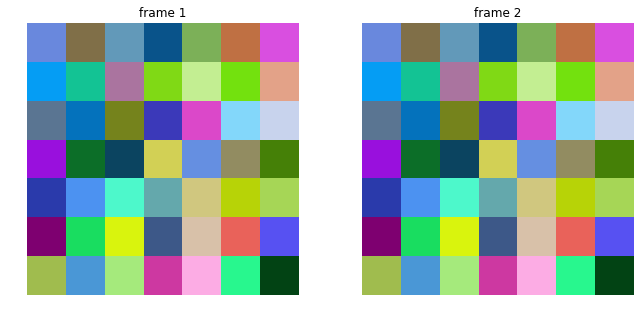

[[1.0000000e+00 2.8439537e-10]]


In [214]:
frame_1 = np.array(create_random_grid())/255
frame_2 = frame_1
input_img_data = np.concatenate((frame_1,frame_2),axis = 2)[None]
pre_image = copy.copy(input_img_data) 

# show the image
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax1.axis("off")
ax1.set_title("frame 1")
_ = ax1.imshow(pre_image[0,:,:,:3],cmap="hot")

ax2 = fig.add_subplot(122)
ax2.axis("off")
ax2.set_title("frame 2")
_ = ax2.imshow(pre_image[0,:,:,3:],cmap="hot")

plt.show()

# plot the predictions of the neural net for this random image
original_preds = cnn.predict(pre_image)
print(original_preds)
# _ = plt.hist(original_preds[0,:])
# plt.show()

# _ = plt.plot(original_preds[0,:],'x')
# plt.show()

In [194]:
cnn.predict(data_left[34,:,:,:][None])

array([[1., 0.]], dtype=float32)

In [195]:
cnn.predict(data_right[5000,:,:,:][None])

array([[0., 1.]], dtype=float32)

In [215]:
# run gradient ascent for n steps
n = 5000
step = 0.05
for i in range(n):
    loss_value, grads_value = cnn_iterate([input_img_data])
    input_img_data += grads_value * step
    if i%500 == 0:
        print('Current loss value:', loss_value)

Current loss value: 2.8439537e-10
Current loss value: 2.9769326e-10
Current loss value: 3.122829e-10
Current loss value: 3.284766e-10
Current loss value: 3.4650793e-10
Current loss value: 3.6657355e-10
Current loss value: 3.8903836e-10
Current loss value: 4.1449427e-10
Current loss value: 4.4352358e-10
Current loss value: 4.76989e-10


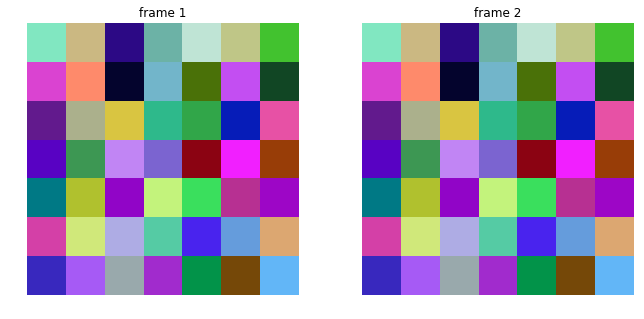

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


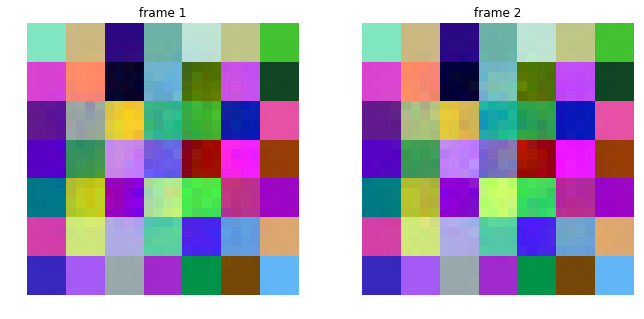

[1.0000000e+00 1.5760163e-12]


In [210]:
# show the image
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax1.axis("off")
ax1.set_title("frame 1")
_ = ax1.imshow(pre_image[0,:,:,:3],cmap="hot")

ax2 = fig.add_subplot(122)
ax2.axis("off")
ax2.set_title("frame 2")
_ = ax2.imshow(pre_image[0,:,:,3:],cmap="hot")

plt.show()

# show the image
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax1.axis("off")
ax1.set_title("frame 1")
_ = ax1.imshow(input_img_data[0,:,:,:3],cmap="hot")

ax2 = fig.add_subplot(122)
ax2.axis("off")
ax2.set_title("frame 2")
_ = ax2.imshow(input_img_data[0,:,:,3:],cmap="hot")

plt.show()

# plot the predictions of the neural net for this random image
new_preds = cnn.predict(input_img_data)
print(new_preds[0])

In [203]:
lefts = 0
for j in range(1000):
    frame_1 = np.array(create_random_grid())/255
    frame_2 = frame_1
    input_img_data = np.concatenate((frame_1,frame_2),axis = 2)[None]
    pre_image = copy.copy(input_img_data) 
    original_preds = cnn.predict(pre_image)[0]
    if np.argmax(original_preds) == 0:
        lefts+=1

In [204]:
lefts

984